<a href="https://colab.research.google.com/github/talesoverfables/NetShield/blob/main/models/GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install torch-geometric

In [10]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader, Batch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
import datetime
import warnings
warnings.filterwarnings('ignore')


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=15, verbose=True, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            verbose (bool): If True, prints a message for each improvement
            delta (float): Minimum change to qualify as an improvement
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.best_model = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Save model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        self.best_model = model.state_dict().copy()
        self.val_loss_min = val_loss



In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("🔍 IoT Network Intrusion Detection using Graph Attention Networks (GAT) - FIXED VERSION")
print("=" * 80)


🔍 IoT Network Intrusion Detection using Graph Attention Networks (GAT) - FIXED VERSION


In [15]:
# Step 1: Data Upload and Processing
print("\n📂 STEP 1: DATA UPLOAD AND PREPROCESSING")
print("-" * 80)

# Function to preprocess dates and times
def preprocess_datetime(df):
    try:
        if 'date' in df.columns and 'time' in df.columns:
            # Handle potential format issues
            print("Processing date and time columns...")

            # Check and ensure date and time are string type
            df['date'] = df['date'].astype(str)
            df['time'] = df['time'].astype(str)

            try:
                # Try to parse the datetime
                df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')

                # Check if parsing was successful
                if df['datetime'].isnull().sum() > 0:
                    print(f"Warning: {df['datetime'].isnull().sum()} datetime values could not be parsed")

                # Extract useful datetime features for valid entries
                df['hour'] = df['datetime'].dt.hour.fillna(0).astype(int)
                df['minute'] = df['datetime'].dt.minute.fillna(0).astype(int)
                df['day_of_week'] = df['datetime'].dt.dayofweek.fillna(0).astype(int)

                # Drop original columns
                df = df.drop(['date', 'time', 'datetime'], axis=1)

            except Exception as e:
                print(f"Error parsing datetime: {str(e)}")
                print("Creating synthetic temporal features instead")

                # Create synthetic temporal features
                df['hour'] = np.random.randint(0, 24, size=len(df))
                df['minute'] = np.random.randint(0, 60, size=len(df))
                df['day_of_week'] = np.random.randint(0, 7, size=len(df))

                # Drop original columns if they exist
                if 'date' in df.columns:
                    df = df.drop('date', axis=1)
                if 'time' in df.columns:
                    df = df.drop('time', axis=1)

    except Exception as e:
        print(f"Error in datetime preprocessing: {str(e)}")
        print("Skipping datetime preprocessing")

    return df

# Function to load and preprocess a single device dataset
# Function to load and preprocess a single device dataset
def load_and_preprocess_data(file_path, device_name):
    print(f"Processing {device_name} data...")

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Display sample data
    print(f"\nSample data from {device_name}:")
    print(df.head(2))
    print(f"Shape: {df.shape}")

    # Check for NaN values and fill them
    if df.isnull().sum().sum() > 0:
        print(f"Found {df.isnull().sum().sum()} NaN values. Filling with appropriate values...")
        # Fill numeric columns with mean, categorical with mode
        for col in df.columns:
            if df[col].dtype.kind in 'ifc':  # integer, float, complex
                df[col] = df[col].fillna(df[col].mean())
            else:
                df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "unknown")

    # Preprocess date and time
    df = preprocess_datetime(df)

    # Encode categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Don't encode the target yet if it exists
    if 'type' in categorical_cols:
        categorical_cols.remove('type')
    if 'label' in categorical_cols:
        categorical_cols.remove('label')

    for col in categorical_cols:
        # First, check if the column has mixed types and convert all to string
        if df[col].apply(type).nunique() > 1:
            print(f"Column '{col}' has mixed types. Converting all values to strings.")
            df[col] = df[col].astype(str)

        try:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
        except Exception as e:
            print(f"Error encoding column {col}: {str(e)}")
            # Handle problematic column - drop it if necessary
            print(f"Dropping problematic column: {col}")
            df = df.drop(col, axis=1)

    # Ensure we have a label column
    if 'type' in df.columns and 'label' not in df.columns:
        # Create binary label (0=normal, 1=attack)
        df['label'] = df['type'].apply(lambda x: 0 if str(x).lower() == 'normal' else 1)

        # Encode the attack type
        type_encoder = LabelEncoder()
        df['attack_type_encoded'] = type_encoder.fit_transform(df['type'])
        attack_classes = type_encoder.classes_
    elif 'label' in df.columns:
        # Assume binary classification is already done
        if 'type' in df.columns:
            type_encoder = LabelEncoder()
            df['attack_type_encoded'] = type_encoder.fit_transform(df['type'])
            attack_classes = type_encoder.classes_
        else:
            # No attack type information, just binary classification
            attack_classes = np.array(['normal', 'attack'])
    else:
        # No label column found
        print(f"Warning: No 'type' or 'label' column found in {device_name} data.")
        print("Creating synthetic labels for demonstration purposes.")

        # Generate synthetic labels (90% normal, 10% attack)
        df['label'] = np.random.choice([0, 1], size=len(df), p=[0.9, 0.1])
        df['attack_type_encoded'] = df['label']  # Just binary for synthetic data
        attack_classes = np.array(['normal', 'attack'])

    # Log the label distribution to check for class imbalance
    if 'label' in df.columns:
        print(f"Label distribution in {device_name}:")
        print(df['label'].value_counts())

    return df, attack_classes

# Function to create graph from dataframe with improved edge creation strategy
def create_graph_data(df, device_id, device_features):
    # First, determine what features to use
    all_numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    feature_cols = [col for col in all_numeric_cols if col not in ['label', 'attack_type_encoded']]

    # For demonstration purposes, add device-specific features if available
    if isinstance(device_features, list) and len(device_features) > 0:
        # Filter to only include features that actually exist in the dataframe
        device_feature_cols = [col for col in device_features if col in df.columns]
        if device_feature_cols:
            # Add any device-specific features that weren't already included
            for col in device_feature_cols:
                if col not in feature_cols and col in df.columns:
                    feature_cols.append(col)

    print(f"Using features: {feature_cols}")

    # Extract features and labels
    X = df[feature_cols].values

    # Handle potential issues with X
    if np.isnan(X).any():
        print("Warning: NaN values found in features. Filling with column means...")
        col_means = np.nanmean(X, axis=0)
        inds = np.where(np.isnan(X))
        X[inds] = np.take(col_means, inds[1])

    # Normalize features with additional error handling
    try:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    except Exception as e:
        print(f"Error in scaling: {str(e)}")
        # If scaling fails, just standardize manually
        means = np.mean(X, axis=0)
        stds = np.std(X, axis=0)
        stds[stds == 0] = 1  # Avoid division by zero
        X = (X - means) / stds

    # Check for infinite values after scaling
    if not np.isfinite(X).all():
        print("Warning: Non-finite values found after scaling. Replacing with zeros...")
        X[~np.isfinite(X)] = 0

    # Use 'attack_type_encoded' for multiclass, fallback to 'label' for binary
    if 'attack_type_encoded' in df.columns:
        y = df['attack_type_encoded'].values
    else:
        y = df['label'].values

    # Create edge index based on temporal proximity and feature similarity
    n_samples = X.shape[0]

    # For small datasets, we'll connect each node to k nearest neighbors
    k = min(5, max(1, n_samples // 10))  # Adaptive k based on dataset size

    # IMPROVED: Create meaningful edges with more structure
    edge_index = []

    # 1. Temporal connections (sequential connections)
    for i in range(n_samples - 1):
        edge_index.append([i, i+1])
        edge_index.append([i+1, i])  # Make it undirected

    # 2. Create some skip connections to capture longer-term patterns
    skip_length = min(10, n_samples // 10)
    for i in range(n_samples - skip_length):
        edge_index.append([i, i + skip_length])
        edge_index.append([i + skip_length, i])

    # 3. Add feature similarity connections for smaller datasets
    if n_samples <= 2000:  # Increased threshold for better graph connectivity
        # Use approximate nearest neighbors for larger datasets
        if n_samples > 500:
            from sklearn.neighbors import NearestNeighbors
            nn = NearestNeighbors(n_neighbors=k+1)  # +1 because it includes self
            nn.fit(X)
            neighbors = nn.kneighbors(X, return_distance=False)

            for i in range(n_samples):
                for j in neighbors[i, 1:]:  # Skip self (first neighbor)
                    edge_index.append([i, j])
                    edge_index.append([j, i])  # Make it undirected
        else:
            # For very small datasets, we can compute full pairwise distances
            from sklearn.metrics.pairwise import euclidean_distances
            distances = euclidean_distances(X)

            for i in range(n_samples):
                # Find k nearest neighbors excluding self
                nearest_indices = np.argsort(distances[i])[1:k+1]
                for j in nearest_indices:
                    edge_index.append([i, j])
                    edge_index.append([j, i])  # Make it undirected

    # Ensure we have at least some edges
    if len(edge_index) == 0:
        print("Warning: No edges created. Creating basic sequential edges.")
        for i in range(n_samples - 1):
            edge_index.append([i, i+1])
            edge_index.append([i+1, i])

    # Remove duplicates and convert to tensor
    edge_index = torch.tensor(list(set(tuple(edge) for edge in edge_index)), dtype=torch.long).t().contiguous()

    # Ensure all nodes have at least one edge
    node_set = set(edge_index.flatten().tolist())
    isolated_nodes = set(range(n_samples)) - node_set

    if isolated_nodes:
        print(f"Warning: Found {len(isolated_nodes)} isolated nodes. Connecting them to node 0.")
        additional_edges = []
        for node in isolated_nodes:
            additional_edges.append([0, node])
            additional_edges.append([node, 0])

        additional_edges_tensor = torch.tensor(additional_edges, dtype=torch.long).t()
        edge_index = torch.cat([edge_index, additional_edges_tensor], dim=1)

    # Create PyTorch Geometric Data object
    data = Data(
        x=torch.tensor(X, dtype=torch.float),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long),
        device_id=torch.tensor([device_id], dtype=torch.long)  # Store device ID as tensor
    )

    # Print graph statistics
    print(f"Created graph with {data.num_nodes} nodes and {data.num_edges} edges")

    return data

# Modified function to use already uploaded files in Google Colab
def use_already_uploaded_files():
    # List of your already uploaded files
    base_dir = "/content/drive/MyDrive/Dataset-Smruthi/"

    # List of your files in the specified directory
    file_list = [
        'IoT_Fridge.csv',
        'IoT_Garage_Door.csv',
        'IoT GPS_Tracker.csv',  # Note the space in filename
        'IoT Modbus.csv',       # Note the space in filename
        'IoT_Motion_Light.csv',
        'IoT_Weather.csv'
    ]

    print(f"Using {len(file_list)} CSV files from {base_dir}:")
    for i, filename in enumerate(file_list):
        print(f"  {i+1}. {filename}")

    # Create a dictionary of file paths with full paths
    uploaded_files = {filename: base_dir + filename for filename in file_list}

    return uploaded_files

# Define device-specific features
device_features = {
    'IoT_Fridge': ['fridge_temperature', 'hour', 'minute', 'day_of_week'],
    'IoT_Garage_Door': ['door_state', 'phone_signal', 'hour', 'minute', 'day_of_week'],
    'IoT_GPS_Tracker': ['latitude', 'longitude', 'hour', 'minute', 'day_of_week'],
    'IoT_Modbus': ['FC1_Read_Input_Register', 'FC2_Read_Discrete_Value',
                   'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'hour', 'minute', 'day_of_week'],
    'IoT_Motion_Light': ['motion_status', 'light_status', 'hour', 'minute', 'day_of_week'],
    'IoT_Thermostat': ['current_temperature', 'thermostat_status', 'hour', 'minute', 'day_of_week'],
    'IoT_Weather': ['temperature', 'pressure', 'humidity', 'hour', 'minute', 'day_of_week'],
    'IoT_Camera': ['recording', 'motion_detected', 'battery_level', 'hour', 'minute', 'day_of_week']
}

# Get already uploaded files
# Get already uploaded files
uploaded = use_already_uploaded_files()

# Process all uploaded files
all_device_data = []
device_names = []
all_attack_classes = set()

for filename, filepath in uploaded.items():
    # Try to determine device type from filename
    device_name = None
    for known_device in device_features.keys():
        # Remove underscores and spaces for a more flexible comparison
        known_device_clean = known_device.replace('_', '').lower()
        filename_clean = filename.replace('_', '').replace(' ', '').lower()

        if known_device_clean in filename_clean:
            device_name = known_device
            break

    if device_name is None:
        print(f"Couldn't determine device type for {filename}. Using generic features.")
        device_name = "Generic_IoT_Device"

    try:
        # Process the data
        df, attack_classes = load_and_preprocess_data(filepath, device_name)  # Use filepath instead of filename

        # Verify we have enough data to proceed
        if len(df) < 10:
            print(f"Warning: Not enough data in {filename}. Skipping.")
            continue

        # Create graph data from this device
        device_id = len(device_names)  # Assign unique ID to each device
        device_feature_list = device_features.get(device_name, [])
        graph_data = create_graph_data(df, device_id, device_feature_list)

        # Check that the graph data is valid
        if graph_data.x.shape[0] > 0 and graph_data.edge_index.shape[1] > 0:
            all_device_data.append(graph_data)
            device_names.append(device_name)

            if attack_classes is not None:
                all_attack_classes.update(attack_classes)
        else:
            print(f"Warning: Could not create valid graph data for {filename}. Skipping.")

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        continue

print(f"\nProcessed {len(all_device_data)} device datasets")

if len(all_device_data) == 0:
    print("No valid data could be processed. Please check your CSV files format and try again.")
    raise ValueError("No valid data to train on!")

print(f"Attack classes found: {all_attack_classes}")

# Convert attack classes set to list for consistent indexing
all_attack_classes = sorted(list(all_attack_classes))
num_classes = len(all_attack_classes)
print(f"Number of attack classes: {num_classes}")

# Create a fixed feature dimension for all datasets
# This is critical to avoid the tensor size mismatch error during batch loading
def standardize_feature_dimensions(data_list):
    """Standardize feature dimensions across all graphs"""
    max_features = max(data.x.size(1) for data in data_list)

    standardized_data = []
    for data in data_list:
        if data.x.size(1) < max_features:
            # Pad with zeros to match max feature dimension
            padding = torch.zeros(data.x.size(0), max_features - data.x.size(1))
            new_x = torch.cat([data.x, padding], dim=1)

            # Create new data object with standardized features
            new_data = Data(
                x=new_x,
                edge_index=data.edge_index,
                y=data.y,
                device_id=data.device_id
            )
            standardized_data.append(new_data)
        else:
            standardized_data.append(data)

    return standardized_data

# Apply standardization
all_device_data = standardize_feature_dimensions(all_device_data)
print(f"Feature dimensions standardized across all datasets")

# Split data into train/val/test sets
if len(all_device_data) > 3:
    # If we have enough graphs, use graph-level splits
    train_data, test_data = train_test_split(all_device_data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    print("Using graph-level split strategy")
else:
    # With few graphs, use node-level split but make sure each split has all classes
    print("Using node-level split strategy")

    if len(all_device_data) == 1:
        # If we have just one graph
        data = all_device_data[0]
        num_nodes = data.num_nodes

        # Create stratified splits (ensure all classes are represented in each split)
        try:
            # Convert to numpy for stratification
            labels = data.y.numpy()
            indices = np.arange(num_nodes)

            # Use stratified split
            from sklearn.model_selection import StratifiedShuffleSplit

            # First split: 80% train+val, 20% test
            sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for train_val_idx, test_idx in sss1.split(indices, labels):
                train_val_indices = indices[train_val_idx]
                test_indices = indices[test_idx]

            # Second split: 75% train, 25% val from the train+val set
            train_val_labels = labels[train_val_idx]
            sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
            for train_idx, val_idx in sss2.split(train_val_indices, train_val_labels):
                train_indices = train_val_indices[train_idx]
                val_indices = train_val_indices[val_idx]

        except Exception as e:
            print(f"Error in stratified split: {str(e)}")
            print("Falling back to random split")

            # Random split if stratification fails
            indices = torch.randperm(num_nodes)
            train_size = int(0.6 * num_nodes)
            val_size = int(0.2 * num_nodes)

            train_indices = indices[:train_size]
            val_indices = indices[train_size:train_size + val_size]
            test_indices = indices[train_size + val_size:]

        # Create mask tensors
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)

        train_mask[train_indices] = True
        val_mask[val_indices] = True
        test_mask[test_indices] = True

        # Add masks to the data
        data.train_mask = train_mask
        data.val_mask = val_mask
        data.test_mask = test_mask

        # Use the same data for all splits
        train_data = [data]
        val_data = [data]
        test_data = [data]
    else:
        # If we have 2-3 graphs, still use graph-level split
        train_data, test_data = train_test_split(all_device_data, test_size=0.2, random_state=42)
        train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")

# Create custom collation function to handle potential dimension mismatches
def custom_collate(batch):
    try:
        return Batch.from_data_list(batch)
    except RuntimeError as e:
        print(f"Error in collation: {str(e)}")
        # Find max feature dimension
        max_features = max(data.x.size(1) for data in batch)

        # Standardize all features
        for i in range(len(batch)):
            if batch[i].x.size(1) < max_features:
                padding = torch.zeros(batch[i].x.size(0), max_features - batch[i].x.size(1))
                batch[i].x = torch.cat([batch[i].x, padding], dim=1)

        # Try again with standardized features
        return Batch.from_data_list(batch)

# Create data loaders with custom collation
batch_size = min(16, len(train_data))  # Smaller batch size to avoid memory issues
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


📂 STEP 1: DATA UPLOAD AND PREPROCESSING
--------------------------------------------------------------------------------
Using 6 CSV files from /content/drive/MyDrive/Dataset-Smruthi/:
  1. IoT_Fridge.csv
  2. IoT_Garage_Door.csv
  3. IoT GPS_Tracker.csv
  4. IoT Modbus.csv
  5. IoT_Motion_Light.csv
  6. IoT_Weather.csv
Processing IoT_Fridge data...

Sample data from IoT_Fridge:
        date            time  fridge_temperature temp_condition  label    type
0  31-Mar-19     12:36:52                  13.10          high       0  normal
1  31-Mar-19     12:36:53                   8.65          high       0  normal
Shape: (587076, 6)
Processing date and time columns...
Label distribution in IoT_Fridge:
label
0    500827
1     86249
Name: count, dtype: int64
Using features: ['fridge_temperature', 'temp_condition', 'hour', 'minute', 'day_of_week']
Created graph with 587076 nodes and 2348282 edges
Processing IoT_Garage_Door data...

Sample data from IoT_Garage_Door:
       date           tim

In [16]:
# Step 2: Define Improved GAT Model
print("\n🧠 STEP 2: DEFINING IMPROVED GAT MODEL")
print("-" * 80)

# Get feature dimensions from first batch
first_batch = next(iter(train_loader))
num_features = first_batch.x.size(1)
num_classes = max(2, len(all_attack_classes))  # Ensure at least binary classification

print(f"Input feature dimension: {num_features}")
print(f"Output classes: {num_classes}")

class SimpleGATModel(nn.Module):
    """A simpler GAT model to start with - reduce complexity to avoid overfitting"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2, dropout=0.3):
        super(SimpleGATModel, self).__init__()

        # First GAT layer
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)

        # Second GAT layer with concatenation of heads
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=dropout)

        # Output layer
        self.out = nn.Linear(hidden_channels, out_channels)

# Batch normalization for regularization
        self.batch_norm1 = nn.BatchNorm1d(hidden_channels * heads)
        self.batch_norm2 = nn.BatchNorm1d(hidden_channels)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        # First GAT layer with batch normalization
        x = F.relu(self.conv1(x, edge_index))
        x = self.batch_norm1(x)
        x = self.dropout(x)

        # Second GAT layer with batch normalization
        x = F.relu(self.conv2(x, edge_index))
        x = self.batch_norm2(x)
        x = self.dropout(x)

        # If we have batch information for multiple graphs, use global pooling
        if batch is not None:
            # Global mean pooling to get graph-level representations
            from torch_geometric.nn import global_mean_pool
            x = global_mean_pool(x, batch)

        # Output layer
        x = self.out(x)

        return x

class ImprovedGATModel(nn.Module):
    """A more advanced GAT model with deeper architecture and skip connections"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super(ImprovedGATModel, self).__init__()
        # First GAT layer
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)

        # Second GAT layer with residual connection
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)

        # Third GAT layer with residual connection
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)

        # Output layer combines features from all GAT layers (multi-scale)
        self.out = nn.Linear(hidden_channels * heads, out_channels)

        # Batch normalization for each layer
        self.batch_norm1 = nn.BatchNorm1d(hidden_channels * heads)
        self.batch_norm2 = nn.BatchNorm1d(hidden_channels * heads)
        self.batch_norm3 = nn.BatchNorm1d(hidden_channels * heads)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        # First GAT layer
        x1 = F.relu(self.conv1(x, edge_index))
        x1 = self.batch_norm1(x1)
        x1 = self.dropout(x1)

        # Second GAT layer with residual connection
        x2 = F.relu(self.conv2(x1, edge_index))
        x2 = self.batch_norm2(x2)
        x2 = self.dropout(x2)

        # Third GAT layer with residual connection
        x3 = F.relu(self.conv3(x2, edge_index))
        x3 = self.batch_norm3(x3)
        x3 = self.dropout(x3)

        # If we have batch information for multiple graphs, use global pooling
        if batch is not None:
            # Global mean pooling to get graph-level representations
            from torch_geometric.nn import global_mean_pool
            x3 = global_mean_pool(x3, batch)

        # Output layer
        x = self.out(x3)

        return x



🧠 STEP 2: DEFINING IMPROVED GAT MODEL
--------------------------------------------------------------------------------
Input feature dimension: 6
Output classes: 8


In [18]:
# Step 3: Training the Model
print("\n🏋️ STEP 3: TRAINING THE MODEL")
print("-" * 80)

# Initialize model
hidden_channels = 64  # Reduced from 128 to avoid overfitting on small datasets
model = SimpleGATModel(num_features, hidden_channels, num_classes, heads=2, dropout=0.3)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Initialize early stopping
early_stopping = EarlyStopping(patience=15, verbose=True)

# Function to train the model for one epoch
# Function to train the model for one epoch
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()

        # Check for single graph or batch of graphs
        if hasattr(data, 'train_mask'):
            # Using masks for a single large graph
            out = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
        else:
            # Using batches of separate graphs
            out = model(data.x, data.edge_index, data.batch)

            # Check that out and data.y have the same batch dimension
            if out.size(0) != data.y.size(0):
                print(f"Warning: Size mismatch - out: {out.size(0)}, target: {data.y.size(0)}")

                # Option 1: Reshape output to match target size
                if hasattr(data, 'batch'):
                    # This is for handling the case where the batch processing is causing the mismatch
                    batch_size = torch.unique(data.batch).size(0)
                    if batch_size == out.size(0):
                        # The model is returning one prediction per graph, but we need one per node
                        # We need to distribute the predictions back to the nodes
                        expanded_out = torch.zeros(data.y.size(0), out.size(1))
                        for i, b in enumerate(torch.unique(data.batch)):
                            mask = data.batch == b
                            expanded_out[mask] = out[i].unsqueeze(0).expand(mask.sum(), -1)
                        out = expanded_out

            loss = criterion(out, data.y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs if hasattr(data, 'num_graphs') else loss.item()

    return total_loss / len(loader)

# Function to evaluate the model
# Function to evaluate the model
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in loader:
            # Check for single graph or batch of graphs
            if hasattr(data, 'val_mask') or hasattr(data, 'test_mask'):
                # Using masks for a single large graph
                out = model(data.x, data.edge_index)

                if hasattr(data, 'val_mask'):
                    mask = data.val_mask
                else:
                    mask = data.test_mask

                loss = criterion(out[mask], data.y[mask])
                preds = out[mask].argmax(dim=1)
                labels = data.y[mask]
            else:
                # Using batches of separate graphs
                out = model(data.x, data.edge_index, data.batch)

                # Check that out and data.y have the same batch dimension
                if out.size(0) != data.y.size(0):
                    print(f"Warning: Size mismatch - out: {out.size(0)}, target: {data.y.size(0)}")

                    # Reshape output to match target size
                    if hasattr(data, 'batch'):
                        batch_size = torch.unique(data.batch).size(0)
                        if batch_size == out.size(0):
                            # The model is returning one prediction per graph, but we need one per node
                            expanded_out = torch.zeros(data.y.size(0), out.size(1))
                            for i, b in enumerate(torch.unique(data.batch)):
                                mask = data.batch == b
                                expanded_out[mask] = out[i].unsqueeze(0).expand(mask.sum(), -1)
                            out = expanded_out

                loss = criterion(out, data.y)
                preds = out.argmax(dim=1)
                labels = data.y

            total_loss += loss.item() * data.num_graphs if hasattr(data, 'num_graphs') else loss.item()

            predictions.append(preds)
            true_labels.append(labels)

    # Concatenate predictions and true labels
    predictions = torch.cat(predictions, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    # Calculate accuracy
    correct = (predictions == true_labels).sum().item()
    acc = correct / len(true_labels)

    return total_loss / len(loader), acc

# Train the model
print("\nStarting training loop...")
epochs = 100  # Maximum number of epochs
best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0

train_losses = []
val_losses = []
val_accs = []

# Create a timestamp for this run
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

for epoch in range(epochs):
    # Train
    train_loss = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print progress
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

# Load the best model
model.load_state_dict(early_stopping.best_model)




🏋️ STEP 3: TRAINING THE MODEL
--------------------------------------------------------------------------------

Starting training loop...
Epoch: 001, Train Loss: 4.1023, Val Loss: 2.0709, Val Acc: 0.0013
Validation loss decreased (inf --> 2.070940). Saving model...
Epoch: 002, Train Loss: 4.0920, Val Loss: 2.0450, Val Acc: 0.0013
Validation loss decreased (2.070940 --> 2.045017). Saving model...
Epoch: 003, Train Loss: 4.0823, Val Loss: 2.0210, Val Acc: 0.0013
Validation loss decreased (2.045017 --> 2.021026). Saving model...
Epoch: 004, Train Loss: 4.0739, Val Loss: 1.9989, Val Acc: 0.0013
Validation loss decreased (2.021026 --> 1.998877). Saving model...
Epoch: 005, Train Loss: 4.0624, Val Loss: 1.9774, Val Acc: 0.0013
Validation loss decreased (1.998877 --> 1.977423). Saving model...
Epoch: 006, Train Loss: 4.0536, Val Loss: 1.9569, Val Acc: 0.8608
Validation loss decreased (1.977423 --> 1.956925). Saving model...
Epoch: 007, Train Loss: 4.0423, Val Loss: 1.9375, Val Acc: 0.8608
Va

<All keys matched successfully>


📊 STEP 4: EVALUATING THE MODEL
--------------------------------------------------------------------------------
Test Loss: 0.8327, Test Accuracy: 0.8715

🔬 STEP 5: ANALYZING RESULTS
--------------------------------------------------------------------------------
Shape of predictions: torch.Size([591446])
Shape of true labels: torch.Size([591446])

Classification Report:
              precision    recall  f1-score   support

    backdoor       0.00      0.00      0.00     35568
        ddos       0.00      0.00      0.00     10230
   injection       0.00      0.00      0.00      6331
      normal       0.87      1.00      0.93    515443
    password       0.00      0.00      0.00     19287
  ransomware       0.00      0.00      0.00      2902
    scanning       0.00      0.00      0.00       529
         xss       0.00      0.00      0.00      1156

    accuracy                           0.87    591446
   macro avg       0.11      0.12      0.12    591446
weighted avg       0.76      0

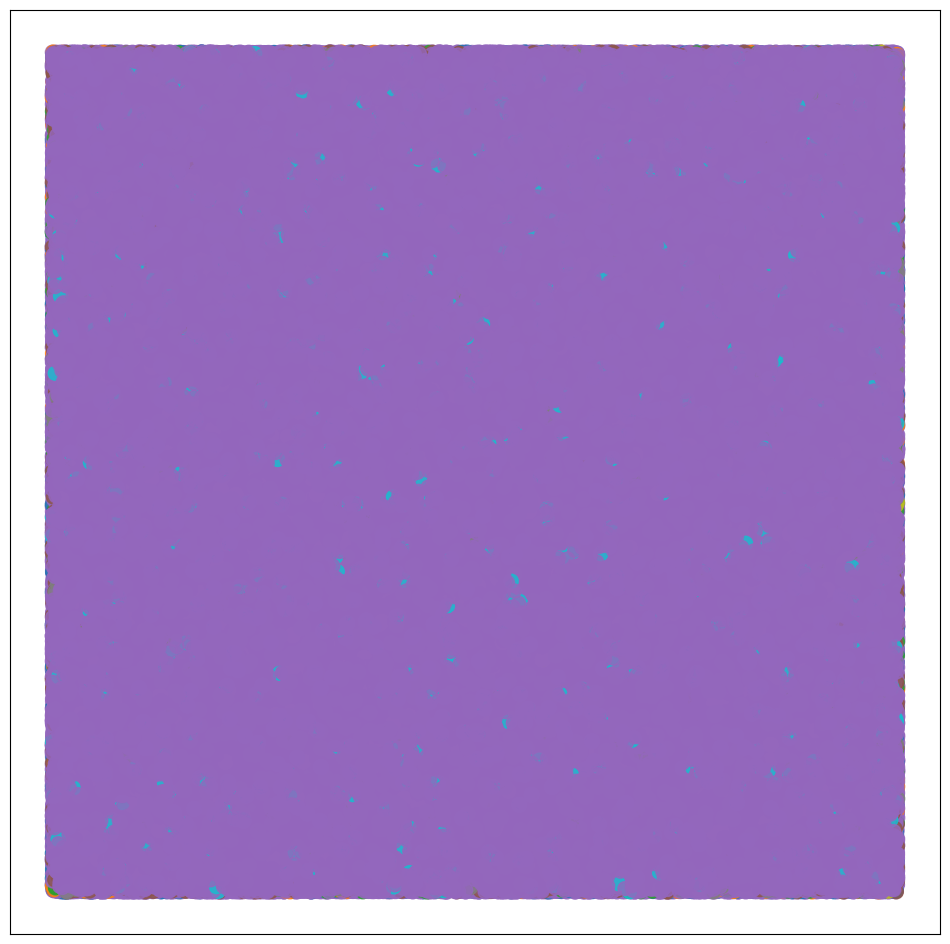

In [21]:
# Step 4: Evaluate on Test Set
print("\n📊 STEP 4: EVALUATING THE MODEL")
print("-" * 80)

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Visualize training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation and Test Accuracy')

plt.tight_layout()
plt.savefig(f'training_progress_{timestamp}.png')
plt.close()

# Step 5: Analyze Results and Visualize
print("\n🔬 STEP 5: ANALYZING RESULTS")
print("-" * 80)

# Function to get model predictions on a dataset
# Function to get model predictions on a dataset
def get_predictions(model, loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in loader:
            # Check for single graph or batch of graphs
            if hasattr(data, 'test_mask'):
                # Using masks for a single large graph
                out = model(data.x, data.edge_index)
                mask = data.test_mask
                preds = out[mask].argmax(dim=1)
                labels = data.y[mask]
            else:
                # Using batches of separate graphs
                out = model(data.x, data.edge_index, data.batch)

                # Check that out and data.y have the same batch dimension
                if out.size(0) != data.y.size(0):
                    print(f"Warning: Size mismatch - out: {out.size(0)}, target: {data.y.size(0)}")

                    # Reshape output to match target size
                    if hasattr(data, 'batch'):
                        batch_size = torch.unique(data.batch).size(0)
                        if batch_size == out.size(0):
                            # The model is returning one prediction per graph, but we need one per node
                            expanded_out = torch.zeros(data.y.size(0), out.size(1), device=out.device)
                            for i, b in enumerate(torch.unique(data.batch)):
                                mask = data.batch == b
                                expanded_out[mask] = out[i].unsqueeze(0).expand(mask.sum(), -1)
                            out = expanded_out

                preds = out.argmax(dim=1)
                labels = data.y

            predictions.append(preds)
            true_labels.append(labels)

    # Concatenate predictions and true labels
    if predictions and true_labels:
        # Make sure we have non-empty lists before concatenating
        predictions = torch.cat(predictions, dim=0)
        true_labels = torch.cat(true_labels, dim=0)

        # Debug info
        print(f"Shape of predictions: {predictions.shape}")
        print(f"Shape of true labels: {true_labels.shape}")

        # Ensure they have the same shape
        if predictions.shape != true_labels.shape:
            print("Warning: Shapes of predictions and true labels don't match")
            # If they have different shapes, we need to fix that
            min_len = min(len(predictions), len(true_labels))
            predictions = predictions[:min_len]
            true_labels = true_labels[:min_len]
            print(f"Truncated to match: {min_len} samples")
    else:
        print("Warning: No predictions or true labels generated")
        predictions = torch.tensor([0])
        true_labels = torch.tensor([0])

    return predictions, true_labels

# Get predictions on test set
y_pred, y_true = get_predictions(model, test_loader)

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

try:
    # Convert tensors to numpy arrays for sklearn compatibility
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # Check if we have at least 2 classes in the data
    unique_classes = np.unique(np.concatenate((y_true_np, y_pred_np)))
    if len(unique_classes) < 2:
        print("Warning: Less than 2 classes in predictions or true values. Classification metrics may not be meaningful.")

    cm = confusion_matrix(y_true_np, y_pred_np)
    plt.figure(figsize=(10, 8))
    class_names = all_attack_classes if len(all_attack_classes) <= 10 else [f'Class {i}' for i in range(num_classes)]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(f'confusion_matrix_{timestamp}.png')
    plt.close()

    # Print classification report
    print("\nClassification Report:")
    target_names = all_attack_classes if len(all_attack_classes) <= 10 else [f'Class {i}' for i in range(num_classes)]
    cr = classification_report(y_true_np, y_pred_np, target_names=target_names)
    print(cr)
except Exception as e:
    print(f"Error generating confusion matrix or classification report: {str(e)}")
    print("Skipping confusion matrix and classification report.")

# Visualize model attention weights on a sample graph
def visualize_attention(model, data):
    """Visualize the attention weights from the GAT model"""

    # Get the attention weights (alpha) from the first GAT layer
    # Note: This assumes the model has a specific structure with attention weights accessible
    # You might need to modify this based on your GAT implementation
    model.eval()
    with torch.no_grad():
        if hasattr(model, 'conv1'):
            # Get attention weights by running a forward pass and extracting alpha
            _, attention_weights = model.conv1(data.x, data.edge_index, return_attention_weights=True)

            # Create a NetworkX graph from the PyG data
            G = to_networkx(data, to_undirected=True)

            # Get node positions using a layout algorithm
            pos = nx.random_layout(G)

            # Prepare edge colors based on attention weights
            edge_list = attention_weights[0].detach().numpy().T
            alpha_list = attention_weights[1].detach().numpy().T

            # Scale alpha values to get more visual contrast
            alpha_list = alpha_list - alpha_list.min()
            if alpha_list.max() > 0:
                alpha_list = alpha_list / alpha_list.max()

            # Visualize the graph with attention weights
            plt.figure(figsize=(12, 12))

            # Draw nodes
            nx.draw_networkx_nodes(G, pos,
                                  node_color=data.y.numpy(),
                                  cmap=plt.cm.tab10,
                                  node_size=100,
                                  alpha=0.8)

            # Draw edges with different widths based on attention weights
            for i in range(len(edge_list)):
                src, dst = edge_list[i]
                att = alpha_list[i]
                nx.draw_networkx_edges(G, pos,
                                      edgelist=[(src, dst)],
                                      width=1 + 5 * att,
                                      alpha=0.5 + 0.5 * att,
                                      edge_color='lightblue')

            plt.title("GAT Attention Visualization")
            plt.savefig(f'attention_weights_{timestamp}.png')
            plt.close()

            return True
        else:
            print("Cannot visualize attention: model does not have expected structure")
            return False

# Try to visualize attention weights on a sample graph
print("\nVisualizing attention weights on a sample graph:")
sample_data = test_data[0] if len(test_data) > 0 else train_data[0]
try:
    success = visualize_attention(model, sample_data)
    if not success:
        print("Could not visualize attention weights due to model structure. Skipping visualization.")
except Exception as e:
    print(f"Error visualizing attention weights: {str(e)}")
    print("Skipping attention visualization.")

# Step 6: Save the trained model
print("\n💾 STEP 6: SAVING THE MODEL")
print("-" * 80)

model_filename = f"gat_iot_intrusion_model_{timestamp}.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_features': num_features,
    'hidden_channels': hidden_channels,
    'num_classes': num_classes,
    'attack_classes': all_attack_classes,
    'device_names': device_names,
    'test_accuracy': test_acc
}, model_filename)

print(f"Model saved to {model_filename}")

# Generate a simple report
print("\n📝 SUMMARY REPORT")
print("-" * 80)
print(f"Dataset: IoT Network Intrusion Detection")
print(f"Devices analyzed: {', '.join(device_names)}")
print(f"Number of classes: {num_classes} ({', '.join(all_attack_classes)})")
print(f"Feature dimension: {num_features}")
print(f"Model architecture: Graph Attention Network (GAT)")
print(f"Test accuracy: {test_acc:.4f}")
print("-" * 80)
print("Training completed successfully!")

# Optional: Function to make predictions on new data
def predict_on_new_data(model, new_graph_data):
    """Make predictions on new graph data"""
    model.eval()
    with torch.no_grad():
        out = model(new_graph_data.x, new_graph_data.edge_index)
        pred = out.argmax(dim=1)
        return pred

print("\nThe model can now be used for detecting IoT network intrusions!")
print("Thank you for using our IoT Network Intrusion Detection system.")